# Geodetic Tools

This notebook demonstrates the basic workflow for creating an activity rate model from geodetic strain. The methodology
is an implementation of the Seismic Hazard Inferred from Tectonics (SHIFT) (Bird & Liu, 2007; Bird et al., 2010)

### The Geodetic Strain Rate Model

In [1]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
import numpy as np
from openquake.hmtk.parsers.strain.strain_csv_parser import ReadStrainCsv

strain_file = 'input_data/average_strain_minimal.csv'
fid = open(strain_file, 'r')

for i, row in enumerate(fid.readlines()):
    if i >= 20:
        break
    print(row)
fid.close()

longitude,latitude,exx,eyy,exy

179.7,-65.75,-6.90E+01,5.37E+01,1.83E+01

-179.7,-65.75,-1.60E+02,2.78E+02,-1.75E+00

-179.1,-65.75,-3.87E+02,5.95E+02,-6.81E+01

-178.5,-65.75,-3.41E-13,7.10E+02,-3.08E+02

-177.9,-65.75,1.73E+02,6.32E+02,-4.03E+02

-177.3,-65.75,6.97E+01,4.39E+02,-2.41E+02

-176.7,-65.75,7.16E+01,3.74E+02,-1.93E+02

-176.1,-65.75,2.85E+01,3.57E+02,-1.62E+02

-175.5,-65.75,7.41E+00,3.41E+02,-1.64E+02

-174.9,-65.75,5.83E+01,2.76E+02,-1.69E+02

-174.3,-65.75,2.43E+02,7.55E+01,-1.19E+02

177.9,-65.25,-6.76E+01,6.56E+01,1.98E+01

178.5,-65.25,-1.06E+02,2.40E+02,-3.86E+01

179.1,-65.25,-1.42E+02,4.11E+02,-7.80E+01

179.7,-65.25,-4.24E+02,5.37E+02,-8.89E+00

-179.7,-65.25,-3.30E+02,4.21E+02,8.48E+00

-179.1,-65.25,-1.41E+02,1.15E+02,6.29E+01

-177.9,-65.25,2.40E+02,7.85E+01,-1.22E+02

-177.3,-65.25,5.65E+01,2.72E+02,-1.73E+02



### Load in the Strain File

In [5]:
import numpy as np
from openquake.hmtk.parsers.strain.strain_csv_parser import ReadStrainCsv

reader = ReadStrainCsv(strain_file)

strain_data = reader.read_data(scaling_factor=1E-9) # Data reported in nanostrain
print('Data loaded ok')



No tectonic regionalisation found in input file!
Data loaded ok


In [ ]:
for iloc in range(0, 20):
    print '%8.3f %8.3f %.8e %.8e %.8e %.8e %.8e' % (strain_data.data['longitude'][iloc],
                                                    strain_data.data['latitude'][iloc],
                                                    strain_data.data['exx'][iloc],
                                                    strain_data.data['eyy'][iloc],
                                                    strain_data.data['exy'][iloc],
                                                    strain_data.data['2nd_inv'][iloc],
                                                    strain_data.data['dilatation'][iloc])

### Adding the Tectonic Regionalisaton

To define a seismic moment rate, the volume of each deforming cell must be known. Therefore the seismogenic coupling depth must be defined. This is done using the regionalisation. In the current example the tectonic regionalisation of Kreemer (2003) is used. The cells can be assigned to this regionalisation using as follows:

In [6]:
from openquake.hmtk.strain.regionalisation.kreemer_regionalisation import KreemerRegionalisation

regionalisation = KreemerRegionalisation()

strain_data = regionalisation.get_regionalisation(strain_data)                              

In [ ]:
for iloc in range(0, 20):
    print '%8.3f %8.3f %.8e %.8e %.8e %.8e %.8e %s' % (strain_data.data['longitude'][iloc],
                                                    strain_data.data['latitude'][iloc],
                                                    strain_data.data['exx'][iloc],
                                                    strain_data.data['eyy'][iloc],
                                                    strain_data.data['exy'][iloc],
                                                    strain_data.data['2nd_inv'][iloc],
                                                    strain_data.data['dilatation'][iloc],
                                                    strain_data.data['region'][iloc])

### Applying the SHIFT Methodology

In [8]:
from openquake.hmtk.strain.shift import Shift

magnitudes = np.arange(5.0, 9.6, 0.1)

modeller = Shift(magnitudes)

Implicit in this methodology are the regionalisation parameters of Bird & Kagan (2004) and Bird et al (2009). The SHIFT methodology assumes that for each cell the activity is modelled via a Tapered Gutenberg-Richter distribution, with the
beta-value and corner magnitude derived according to the region type assigned by Bird & Kagan (2004)

In [ ]:
for key in modeller.regionalisation.keys():
    print key
    print modeller.regionalisation[key]

In [9]:
# Get the activity rate
modeller.calculate_activity_rate(strain_data, cumulative=False)

Text(0, 0.5, 'Incremental Rate')

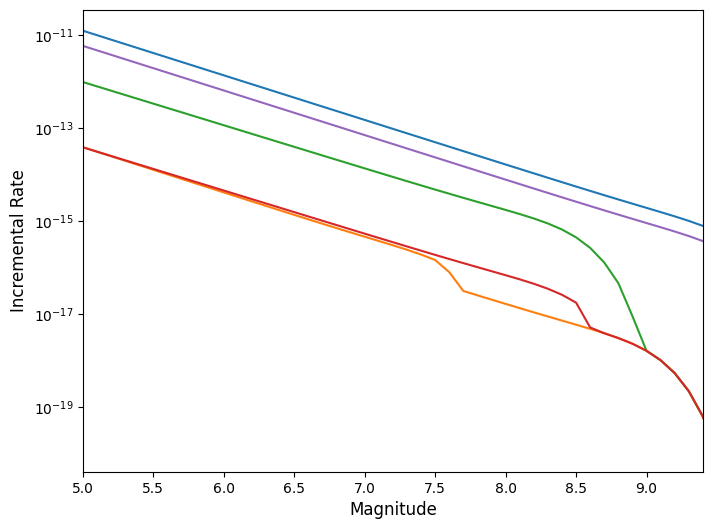

In [10]:
import matplotlib.pyplot as plt

# Show a sample of 8 random cells
sampler = np.random.randint(0, strain_data.get_number_observations(), 5)

plt.figure(figsize=(8.0, 6.0))
for sample in sampler:
    plt.semilogy(magnitudes, modeller.strain.seismicity_rate[sample, :])
plt.xlim(5.0, 9.4)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Incremental Rate', fontsize=12)


### Export the Activity Model to a CSV

In [12]:
from openquake.hmtk.parsers.strain.strain_csv_parser import WriteStrainCsv

output_file = 'output_data/SHIFT_Demo_Output1.csv'

writer = WriteStrainCsv(output_file)

writer.write_file(modeller.strain, scaling_factor=1E-9)

Writing strain data to file output_data/SHIFT_Demo_Output1.csv
done!
